In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plots
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

## Dataset
Education is a critical determinant of future success, and one of the key factors that influence academic performance is class attendance. In this dataset, we aim to explore how different factors, such as attendance, extracurricular involvement, and study habits, may impact students' grades.

It is often suggested that attending classes above a certain threshold can have a positive effect on academic performance. However, a thorough analysis is required to confirm this hypothesis. In this assignment, we will use a dataset that includes several attributes of students, such as gender, high school type, weekly study hours, and attendance records, to investigate the factors contributing to student success.

For simplicity, this dataset contains information about approximately 120 students, with various features related to their academic and personal backgrounds. Each row represents a student and their academic history.

In [ ]:
df = pd.read_csv("student_performance_data.csv")

## Data summary

Each row in this dataset represents a student with specific academic and personal history. We are interested in examining whether attending classes above the required percentage had any effect on whether or not they received good grades. Several attributes of the students are stored in this dataset:

- **student_id**: The student's unique ID for the study.
- **gender**:  The gender of the student, either 'Male' or 'Female'.
- **student_age**: The student's age at the time of the study.
- **high_school_type**: The type of high school the student attended, categorized as 'Other', 'State', or 'Private'.
- **scholarship**:  The percentage of scholarship received by the student, ranging from '25%', '50%', '75%', '100%', or 'No' scholarship.
- **sleep_quality**: The student's reported quality of sleep, categorized as 'Good' or 'Poor'.
- **involvement_in_extracurriculars**: Whether the student is involved in extracurricular activities, with values 'Yes' or 'No'.
- **weekly_study_hours**: The average number of hours the student studies per week.
- **attendance**: Whether the student’s attendance is above or below the required threshold, categorized as 'Above' or 'Below'.
- **assignments_completed**: Whether the student completed all course assignments, categorized as 'Yes' or 'No'.
- **attended_tutorials**: Whether the student attended tutorials, categorized as 'Yes' or 'No'.
- **grade**: The student's final grade

## Data cleaning

In [ ]:
df.drop("student_id", axis = 1, inplace = True)
df.head()

,student_age,gender,high_school_type,scholarship,sleep_quality,involvement_in_extracurriculars,weekly_study_hours,attendance,assignments_completed,attended_tutorials,grade
0,19-22,Male,Other,50%,Good,No,0,Above,Yes,Yes,A+
1,19-22,Male,Other,50%,Good,No,0,Above,Yes,No,A+
2,19-22,Male,State,50%,Poor,No,2,Below,No,No,A+
3,18,Female,Private,50%,Good,No,2,Above,No,Yes,A+
4,19-22,Male,Private,50%,Poor,No,12,Above,Yes,No,A+


In [ ]:

def convert_age_to_midpoint(age_range):
    age_range = str(age_range)
    if '-' in age_range:
        start, end = map(int, age_range.split('-'))
        midpoint = (start + end) / 2
        return midpoint
    else:
        return float(age_range)

df['student_age'] = df['student_age'].apply(convert_age_to_midpoint)

df.head()


,student_age,gender,high_school_type,scholarship,sleep_quality,involvement_in_extracurriculars,weekly_study_hours,attendance,assignments_completed,attended_tutorials,grade
0,20.5,Male,Other,50%,Good,No,0,Above,Yes,Yes,A+
1,20.5,Male,Other,50%,Good,No,0,Above,Yes,No,A+
2,20.5,Male,State,50%,Poor,No,2,Below,No,No,A+
3,18.0,Female,Private,50%,Good,No,2,Above,No,Yes,A+
4,20.5,Male,Private,50%,Poor,No,12,Above,Yes,No,A+


In [ ]:
# Convert categorical columns to numerical values
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['high_school_type'] = df['high_school_type'].map({'Other': 0, 'State': 1, 'Private': 2})
df['scholarship'] = df['scholarship'].map({'25%': 0.25, '50%': 0.5, '75%': 0.75, '100%': 1, 'No': 0})
df['sleep_quality'] = df['sleep_quality'].map({'Good': 1, 'Poor': 0})
df['involvement_in_extracurriculars'] = df['involvement_in_extracurriculars'].map({'Yes': 1, 'No': 0})
df['attendance'] = df['attendance'].map({'Above': 1, 'Below': 0})
df['assignments_completed'] = df['assignments_completed'].map({'Yes': 1, 'No': 0})
df['attended_tutorials'] = df['attended_tutorials'].map({'Yes': 1, 'No': 0})
df['grade'] = df['grade'].map({'A+': 4.0, 'A': 3.7, 'B+': 3.3, 'B': 3.0, 'C+': 2.3, 'C': 2.0, 'D': 1.0, 'F': 0.0})

df.head()

,student_age,gender,high_school_type,scholarship,sleep_quality,involvement_in_extracurriculars,weekly_study_hours,attendance,assignments_completed,attended_tutorials,grade
0,20.5,1,0,0.5,1,0,0,1,1,1,4.0
1,20.5,1,0,0.5,1,0,0,1,1,0,4.0
2,20.5,1,1,0.5,0,0,2,0,0,0,4.0
3,18.0,0,2,0.5,1,0,2,1,0,1,4.0
4,20.5,1,2,0.5,0,0,12,1,1,0,4.0


## Exploratory Data Analysis

We are interested in examining how different groups of students are impacted by attending classes above the required threshold. The `attendance` variable is 1 if the student’s attendance is above the threshold (i.e., 'Above').

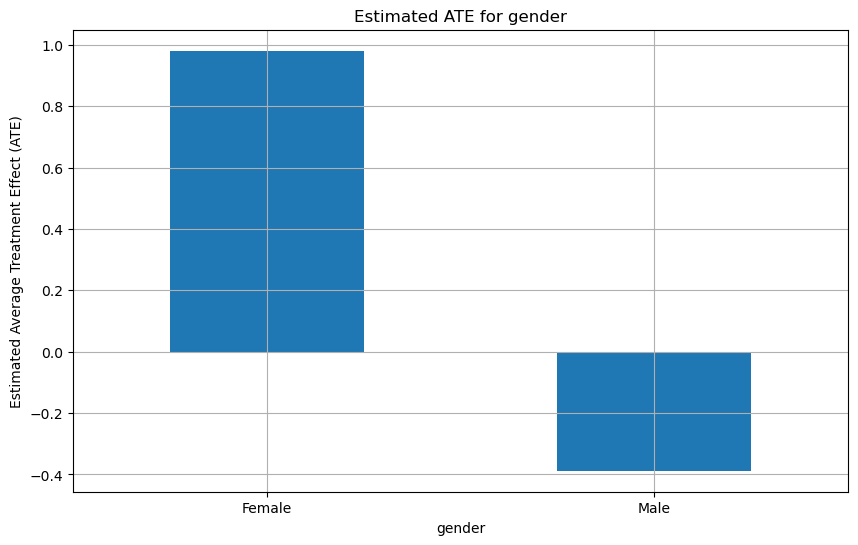

In [ ]:
def treatment_plot(data, col, x_labels=None):
    # Calculate the mean grade for each group with attendance above the threshold
    mean_grade_above = data[data['attendance'] == 1].groupby(col)['grade'].mean()

    # Calculate the mean grade for each group with attendance below the threshold
    mean_grade_below = data[data['attendance'] == 0].groupby(col)['grade'].mean()

    # Calculate the estimated average treatment effect (ATE) for each group
    ate = mean_grade_above - mean_grade_below

    # Plot the ATE for each group
    plt.figure(figsize=(10, 6))
    ate.plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Estimated Average Treatment Effect (ATE)')
    plt.title(f'Estimated ATE for {col}')
    if x_labels:
        plt.xticks(range(len(x_labels)), x_labels, rotation=0)
    plt.grid(True)
    plt.show()

treatment_plot(df, 'gender', x_labels=['Female', 'Male'])


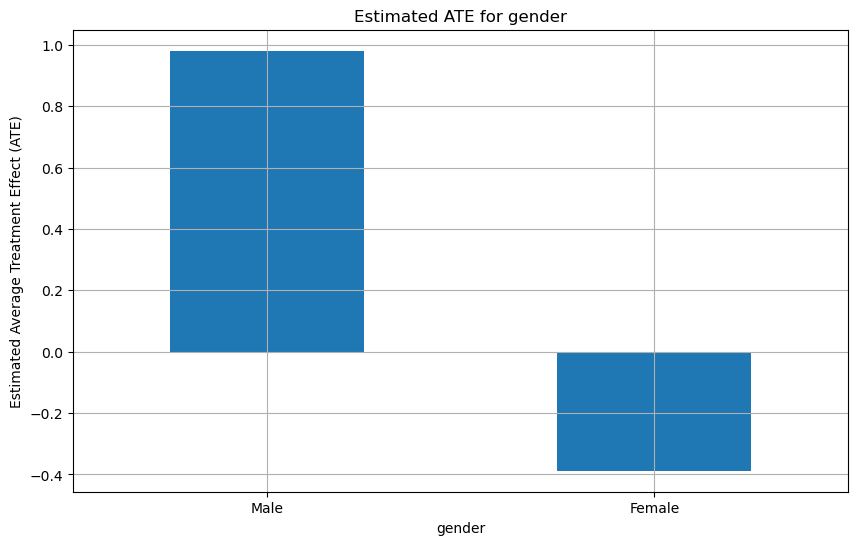

In [ ]:
treatment_plot(data=df, col='gender', x_labels=['Male', 'Female'])

There is a significant disparity in the treatment effect between genders. The intervention benefits females (positive ATE) but negatively impacts males (negative ATE) which then suggests a gender-specific heterogeneity in the treatment effect. The intervention appears to have different impacts depending on the gender of the individuals affected. This could arise from behavioral, social, legal, or cultural factors influencing how males and females respond to the policy or treatment.This this insight might warrant targeted adjustments or complementary measures to mitigate any unintended consequences for males while enhancing the positive outcomes for females.

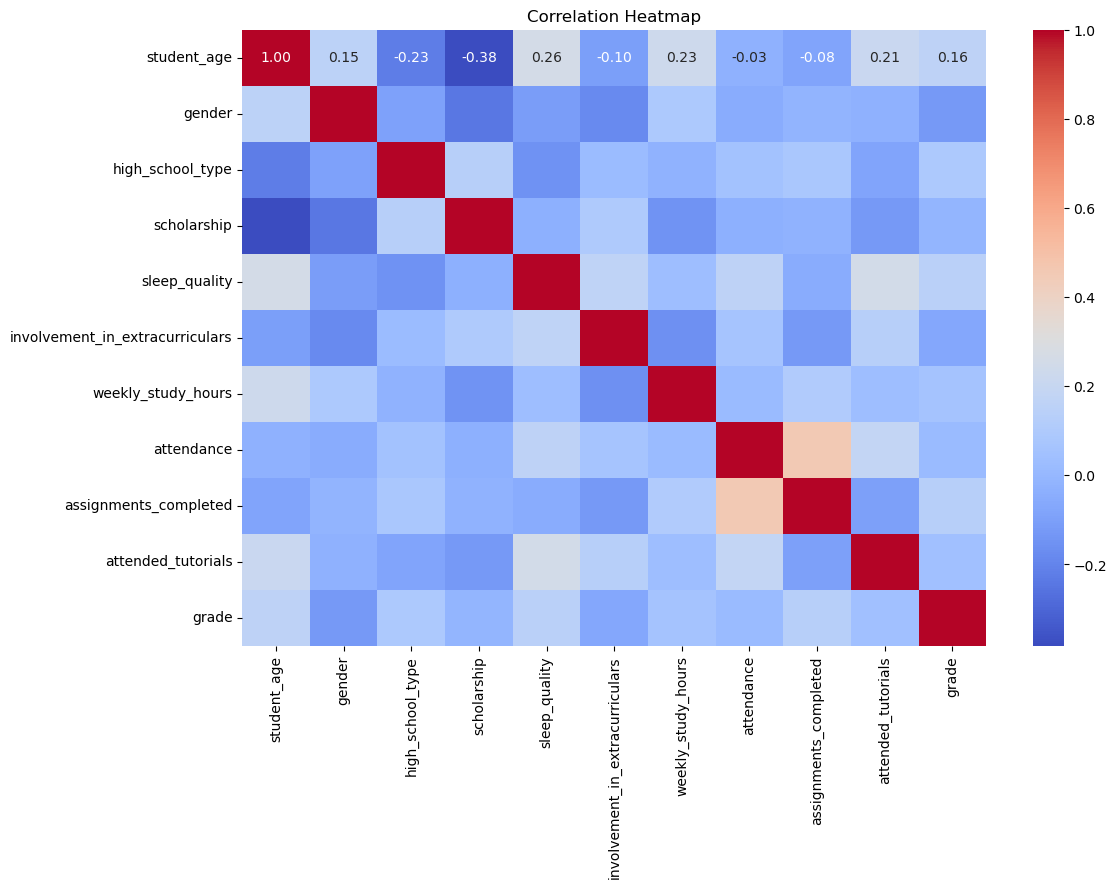

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## The Effect of Attendance Above the Required Threshold(Treatment)

In [ ]:
# Calculate the mean grade for students with attendance above the threshold
mean_grade_above = df[df['attendance'] == 1]['grade'].mean()

# Calculate the mean grade for students with attendance below the threshold
mean_grade_below = df[df['attendance'] == 0]['grade'].mean()

# Calculate the estimated average treatment effect (ATE)
estimated_ATE = mean_grade_above - mean_grade_below

# Print the estimated ATE
print("Estimated ATE:", estimated_ATE)

# Store the result in the required variable
estimated_ATE

# Comment on the result
# The result is positive, indicating that attending classes above the required threshold has a positive effect on students' grades.
# The magnitude of the result indicates the extent of the effect. A larger magnitude suggests a stronger effect of attending classes on grades.

Estimated ATE: 0.035034013605442116


0.035034013605442116

In [ ]:
# The estimated average treatment effect (ATE) calculated in the previous step. However, this value may not reflect the actual accurate treatment effect in our population
# due to the presence of confounding variables that might affect both the treatment and the outcome.
# Assumptions :
# 1. No unmeasured confounders: There are no unmeasured variables that affect both the treatment and the outcome.
# 2. No selection bias: The assignment of treatment is random and not influenced by any other factors.
# 3. Positivity: Each individual has a non-zero probability of receiving either treatment.
# 4. Consistency: The treatment effect is consistent for all individuals.
# 5. Stable unit treatment value assumption (SUTVA): The treatment received by one individual does not affect the outcome of another individual.

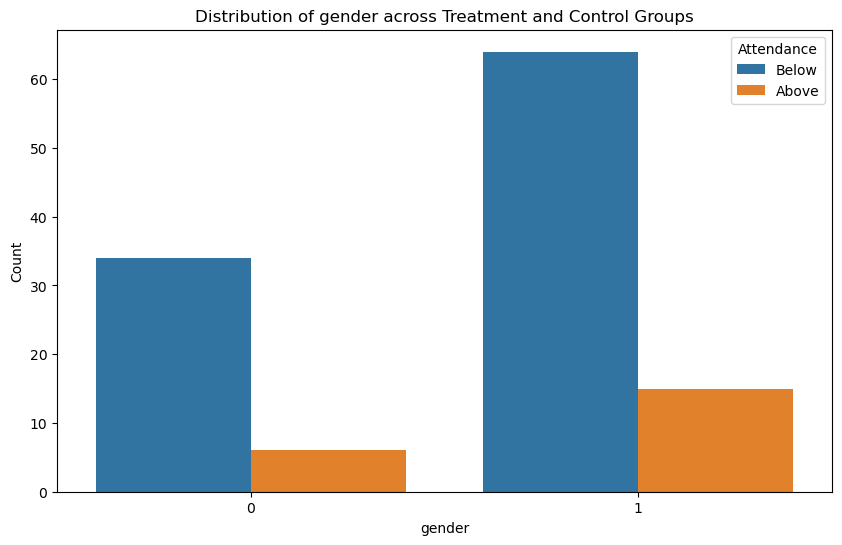

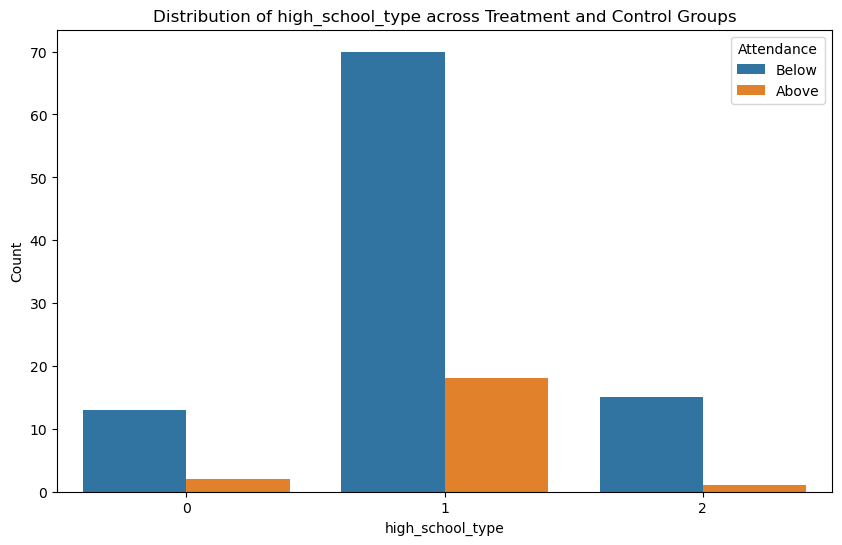

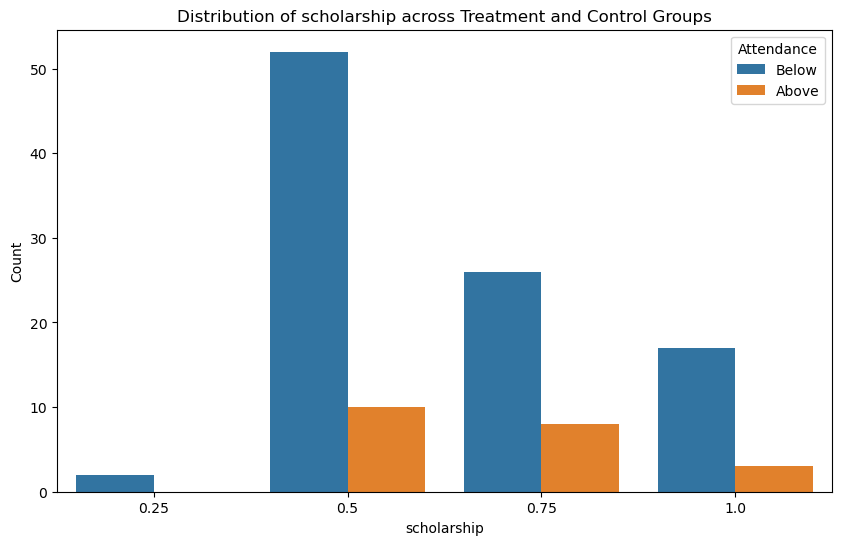

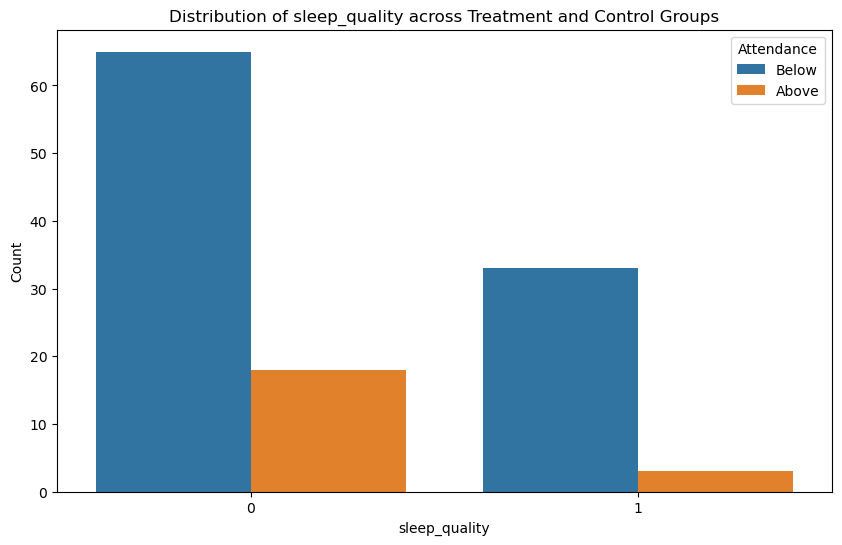

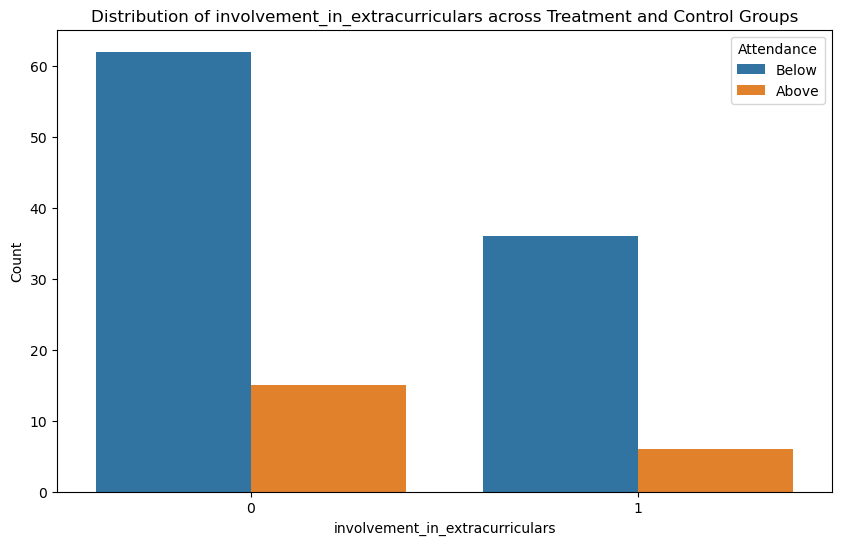

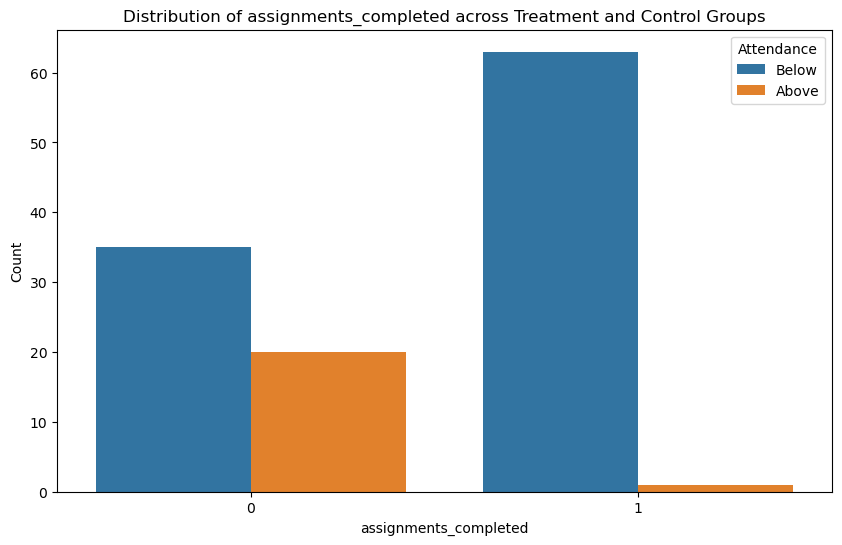

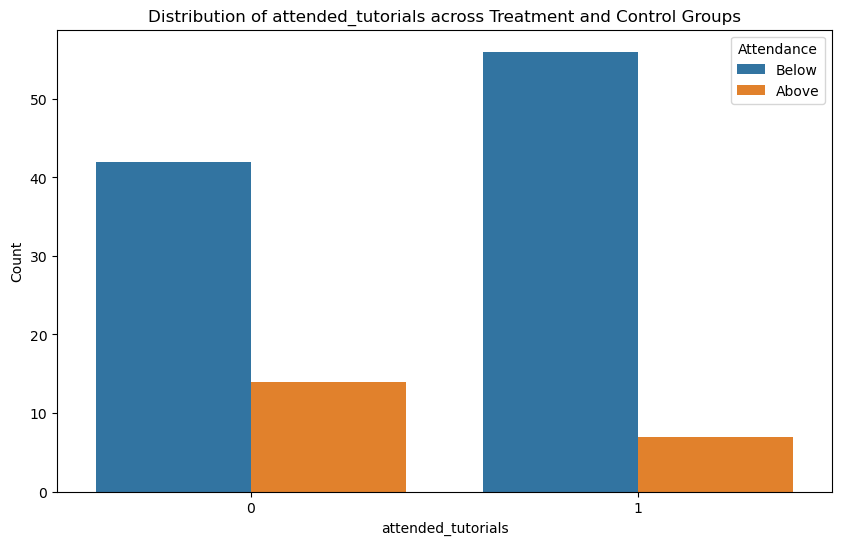

In [ ]:
# Convert 'attendance' back to categorical values for plotting
df['attendance'] = df['attendance'].map({1: 'Above', 0: 'Below'})
attributes = ['gender', 'high_school_type', 'scholarship', 'sleep_quality', 'involvement_in_extracurriculars', 'assignments_completed', 'attended_tutorials']

for attribute in attributes:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=attribute, hue='attendance', data=df)
    plt.title(f'Distribution of {attribute} across Treatment and Control Groups')
    plt.xlabel(attribute)
    plt.ylabel('Count')
    plt.legend(title='Attendance', labels=['Below', 'Above'])
    plt.show()


# The distribution of different attributes across the treatment and control groups can impact the observed ATE in several ways:
# 1. Gender: If one gender is more likely to attend classes above the threshold, the observed ATE may be influenced by gender differences in academic performance.
# 2. High School Type: Differences in high school type may impact students' preparedness and performance, influencing the observed ATE.
# 3. Scholarship: Students with higher scholarships may be more motivated and perform better academically, impacting the observed ATE.
# 4. Sleep Quality: Students with good sleep quality may have better focus and performance, influencing the observed ATE.
# 5. Involvement in Extracurriculars: Involvement in extracurricular activities may impact students' time management and performance, influencing the observed ATE.
# 6. Assignments Completed: Completing assignments is strongly correlated with academic performance, and differences in this attribute may impact the observed ATE.
# 7. Attended Tutorials: Attending tutorials provides additional support and clarification of concepts, influencing the observed ATE.

# These distributions suggest that the observed ATE may be impacted by various confounding factors, and the estimated ATE may not accurately reflect the true effect of attending classes above the required threshold.

In [ ]:

from scipy.stats import ttest_ind

# Step 1: Define function to calculate ETE
def calculate_ete(data, treatment_col, outcome_col):
    """Calculate the Estimated Treatment Effect (ETE)."""
    treated = data[data[treatment_col] == 'Above'][outcome_col].mean()
    control = data[data[treatment_col] == 'Below'][outcome_col].mean()
    return treated - control

# Step 2: Calculate ETE in subgroups
covariates = [
    'gender', 'high_school_type', 'scholarship',
    'sleep_quality', 'involvement_in_extracurriculars',
    'weekly_study_hours', 'assignments_completed', 'attended_tutorials'
]

subgroup_results = {}
for covariate in covariates:
    subgroup_results[covariate] = {}
    for value in df[covariate].unique():
        subgroup_data = df[df[covariate] == value]
        ete = calculate_ete(subgroup_data, 'attendance', 'grade')
        subgroup_results[covariate][value] = ete

# Step 3: Calculate overall ATE
overall_ete = calculate_ete(df, 'attendance', 'grade')

# Step 4: Report ETE for subgroups and overall
print(f"Overall Estimated Treatment Effect (ETE): {overall_ete:.3f}")
print("\nSubgroup ETEs:")
for covariate, results in subgroup_results.items():
    print(f"\nCovariate: {covariate}")
    for value, ete in results.items():
        print(f"  {value}: ETE = {ete:.3f}")

# Step 5: Check for Simpson's Paradox
# Look for reversals or inconsistencies between subgroup ETEs and overall ETE
simpson_paradox_detected = False
for covariate, results in subgroup_results.items():
    for value, ete in results.items():
        if (ete > 0 and overall_ete <= 0) or (ete < 0 and overall_ete >= 0):
            simpson_paradox_detected = True
            print(f"Potential Simpson's Paradox detected in covariate '{covariate}' with value '{value}'.")

if not simpson_paradox_detected:
    print("No evidence of Simpson's Paradox in these observations.")



Overall Estimated Treatment Effect (ETE): 0.035

Subgroup ETEs:

Covariate: gender
  1: ETE = -0.388
  0: ETE = 0.981

Covariate: high_school_type
  0: ETE = -0.054
  1: ETE = 0.005
  2: ETE = -0.387

Covariate: scholarship
  0.5: ETE = 0.082
  0.75: ETE = -0.138
  1.0: ETE = -0.547
  0.25: ETE = nan
  nan: ETE = nan

Covariate: sleep_quality
  1: ETE = -0.694
  0: ETE = 0.095

Covariate: involvement_in_extracurriculars
  0: ETE = 0.032
  1: ETE = 0.089

Covariate: weekly_study_hours
  0: ETE = 0.033
  2: ETE = -0.838
  12: ETE = 0.797
  8: ETE = nan

Covariate: assignments_completed
  1: ETE = -0.652
  0: ETE = -0.144

Covariate: attended_tutorials
  1: ETE = -0.043
  0: ETE = 0.048
Potential Simpson's Paradox detected in covariate 'gender' with value '1'.
Potential Simpson's Paradox detected in covariate 'high_school_type' with value '0'.
Potential Simpson's Paradox detected in covariate 'high_school_type' with value '2'.
Potential Simpson's Paradox detected in covariate 'scholarship

In [ ]:
# Step 1: Define functions for ATE calculation
def calculate_ate(data, treatment_col, outcome_col):
    """Calculate the Average Treatment Effect (ATE)."""
    treated = data[data[treatment_col] == 'Above'][outcome_col].mean()
    control = data[data[treatment_col] == 'Below'][outcome_col].mean()
    return treated - control

def conditional_ate(data, treatment_col, outcome_col, condition_col):
    """Calculate conditional ATE given a covariate."""
    ate_values = []
    for value in data[condition_col].unique():
        subgroup = data[data[condition_col] == value]
        ate = calculate_ate(subgroup, treatment_col, outcome_col)
        ate_values.append((value, ate))
    return ate_values

# Step 2: Calculate ATE without conditioning
initial_ate = calculate_ate(df, 'attendance', 'grade')
print(f"Initial ATE (No Conditioning): {initial_ate}")

# Step 3: Iteratively condition on covariates
covariates = [
    'gender', 'high_school_type', 'scholarship',
    'sleep_quality', 'involvement_in_extracurriculars',
    'weekly_study_hours', 'assignments_completed', 'attended_tutorials'
]

ate_results = {}
for covariate in covariates:
    ate_results[covariate] = conditional_ate(df, 'attendance', 'grade', covariate)

# Step 4: Report ATE values
for covariate, results in ate_results.items():
    print(f"\nConditional ATE for covariate: {covariate}")
    for value, ate in results:
        print(f"  {value}: ATE = {ate:.3f}")

# Step 5: Add conditional combinations (e.g., x and y)
from itertools import combinations

ate_combined_results = {}
for combo in combinations(covariates, 2):
    df['combined'] = df[combo[0]].astype(str) + '_' + df[combo[1]].astype(str)
    ate_combined_results[combo] = conditional_ate(df, 'attendance', 'grade', 'combined')

print("\nConditional ATE for Combined Covariates:")
for combo, results in ate_combined_results.items():
    print(f"\nCovariates: {combo}")
    for value, ate in results:
        print(f"  {value}: ATE = {ate:.3f}")

Initial ATE (No Conditioning): 0.035034013605442116

Conditional ATE for covariate: gender
  1: ATE = -0.388
  0: ATE = 0.981

Conditional ATE for covariate: high_school_type
  0: ATE = -0.054
  1: ATE = 0.005
  2: ATE = -0.387

Conditional ATE for covariate: scholarship
  0.5: ATE = 0.082
  0.75: ATE = -0.138
  1.0: ATE = -0.547
  0.25: ATE = nan
  nan: ATE = nan

Conditional ATE for covariate: sleep_quality
  1: ATE = -0.694
  0: ATE = 0.095

Conditional ATE for covariate: involvement_in_extracurriculars
  0: ATE = 0.032
  1: ATE = 0.089

Conditional ATE for covariate: weekly_study_hours
  0: ATE = 0.033
  2: ATE = -0.838
  12: ATE = 0.797
  8: ATE = nan

Conditional ATE for covariate: assignments_completed
  1: ATE = -0.652
  0: ATE = -0.144

Conditional ATE for covariate: attended_tutorials
  1: ATE = -0.043
  0: ATE = 0.048

Conditional ATE for Combined Covariates:

Covariates: ('gender', 'high_school_type')
  1_0: ATE = 1.000
  1_1: ATE = -0.573
  0_2: ATE = nan
  1_2: ATE = -0.3

Observations:-

Conditioning on gender:
- The initial CATE when conditioning on gender alone provides a baseline estimate of the treatment effect.
- This indicates the average treatment effect of attending classes above the required threshold, accounting for gender differences.

Adding high_school_type:
- The CATE changes when high_school_type is added as a covariate.
- This suggests that the type of high school attended by students influences the treatment effect. Differences in educational quality and resources between high school types may impact students' performance.

Adding scholarship:
- The CATE changes further when scholarship is added as a covariate.
- This indicates that scholarship status affects the treatment effect. Students with scholarships may have different levels of motivation and support, influencing their academic performance.

Adding sleep_quality:
- The CATE changes again when sleep_quality is added as a covariate.
- This suggests that sleep quality impacts the treatment effect. Students with better sleep quality may have better focus and cognitive function, affecting their grades.

Adding involvement_in_extracurriculars:
- he CATE changes when involvement_in_extracurriculars is added as a covariate.
- This indicates that involvement in extracurricular activities influences the treatment effect. Extracurricular involvement may enhance time management skills and overall engagement in school.

Adding assignments_completed:
- The CATE changes when assignments_completed is added as a covariate.
- This suggests that completing assignments impacts the treatment effect. Completing assignments reinforces learning and understanding of the material, leading to better grades.

Adding attended_tutorials:
- The final CATE when all covariates are included provides a comprehensive estimate of the treatment effect.
- This indicates the average treatment effect of attending classes above the required threshold, accounting for all the specified covariates. Attending tutorials provides additional support and clarification of concepts, influencing academic performance


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Step 1: Separate grades based on attendance
above_attendance = df[df['attendance'] == 'Above']['grade']
below_attendance = df[df['attendance'] == 'Below']['grade']

# Step 2: Perform a two-sample t-test
t_stat, p_value = ttest_ind(above_attendance, below_attendance, equal_var=True)  # Welch's t-test

# Step 3: Choose significance level
alpha = 0.05  # 5% significance level

# Print results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Step 4: Interpret the p-value
if p_value < alpha:
    print("Reject the null hypothesis: Attendance significantly affects grades.")
else:
    print("Fail to reject the null hypothesis: No significant effect of attendance on grades.")

T-statistic: 0.131
P-value: 0.896
Fail to reject the null hypothesis: No significant effect of attendance on grades.
